## Malicious URLs

Dataset Source: https://www.kaggle.com/datasets/sid321axn/malicious-urls-dataset 

#### Import Necessary Libraries

In [1]:
import os, sys
os.environ['TOKENIZERS_PARALLELISM']='false'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datasets
from datasets import Dataset, DatasetDict

import torch

import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import TrainingArguments, Trainer, set_seed, DataCollatorWithPadding

import evaluate

!git lfs install

Git LFS initialized.


#### Display Library Versions

In [2]:
print("Python:".rjust(15), sys.version[0:6])
print("NumPy:".rjust(15), np.__version__)
print("Pandas:".rjust(15), pd.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("Torch:".rjust(15), torch.__version__)
print("Evaluate:".rjust(15), evaluate.__version__)

        Python: 3.9.12
         NumPy: 1.24.3
        Pandas: 2.0.1
      Datasets: 2.11.0
  Transformers: 4.27.4
         Torch: 2.0.0
      Evaluate: 0.4.0


#### Load & Start Preprocessing Dataset

In [3]:
data = pd.read_csv("malicious_phish.csv")

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [4]:
names = ["text", 
         "label"]

data_types = {
    "text": str, 
    "label": str,
    }

data = pd.read_csv("malicious_phish.csv", 
                   names=names, 
                   dtype=data_types,
                   header=0)

data['text'] = data['text'].drop_duplicates().reset_index(drop=True)

data['label'] = data['label'].apply(lambda x: x.strip())

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 641119 entries, 0 to 641118
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    641119 non-null  object
 1   label   641119 non-null  object
dtypes: object(2)
memory usage: 14.7+ MB


#### Define Dictionaries to Convert Between String & Integer Class Values

In [5]:
unique_labels = data['label'].unique()

id2label = {idx:label for idx, label in enumerate(unique_labels)}
label2id = {label:idx for idx, label in enumerate(unique_labels)}

NUM_OF_LABELS = len(unique_labels)

print(unique_labels)
print(NUM_OF_LABELS)
print(label2id)
print(id2label)

['phishing' 'benign' 'defacement' 'malware']
4
{'phishing': 0, 'benign': 1, 'defacement': 2, 'malware': 3}
{0: 'phishing', 1: 'benign', 2: 'defacement', 3: 'malware'}


#### Visual: Histogram of Text Lengths

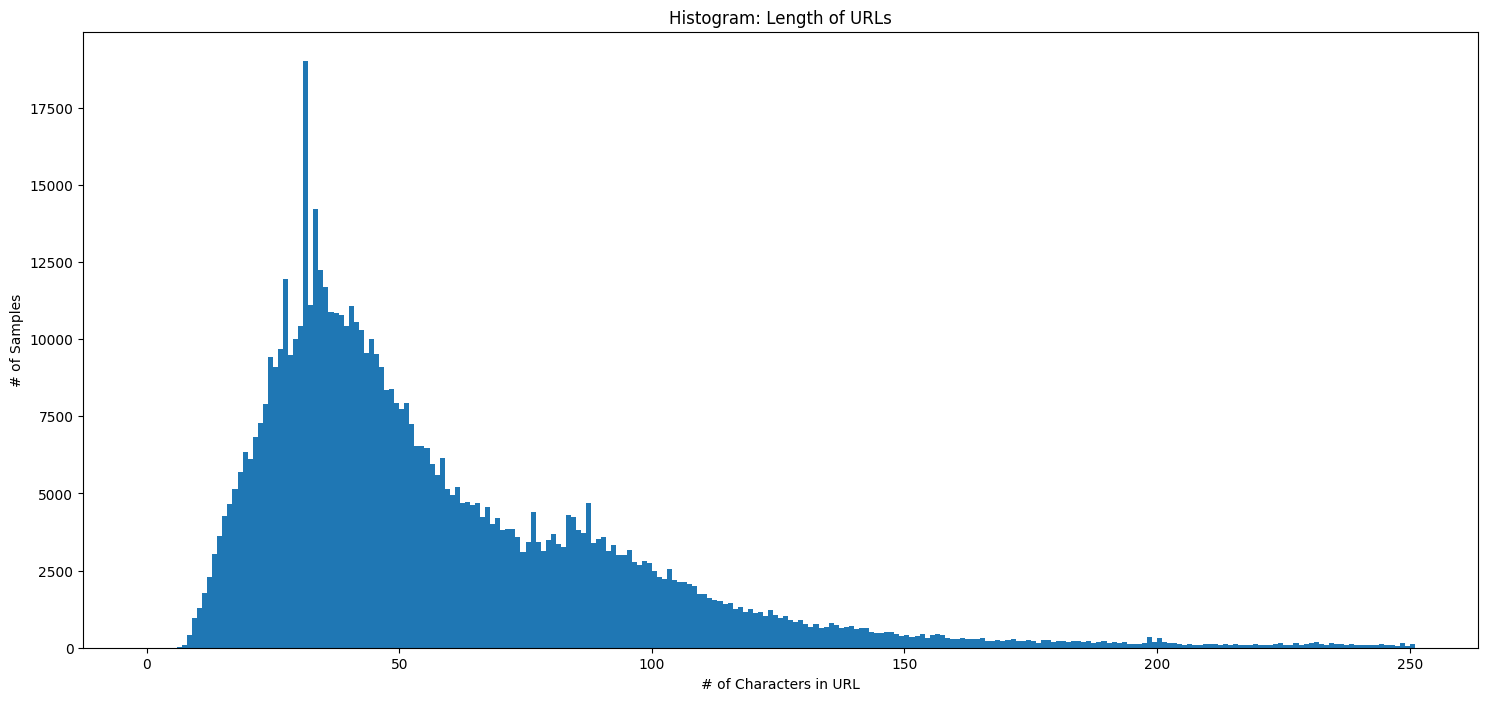

The maximum length of the URLs is 2175 characters.


In [6]:
data['text_length'] = data['text'].str.len()

n_bin=250
data.hist('text_length', grid=False, figsize=(18,8), range=(0,n_bin + 1), bins=(n_bin + 1))
plt.title('Histogram: Length of URLs')
plt.xlabel('# of Characters in URL')
plt.ylabel('# of Samples')
plt.show()

print(f"The maximum length of the URLs is {max(data['text_length'])} characters.")

#### Visual: Tweet Length by Class

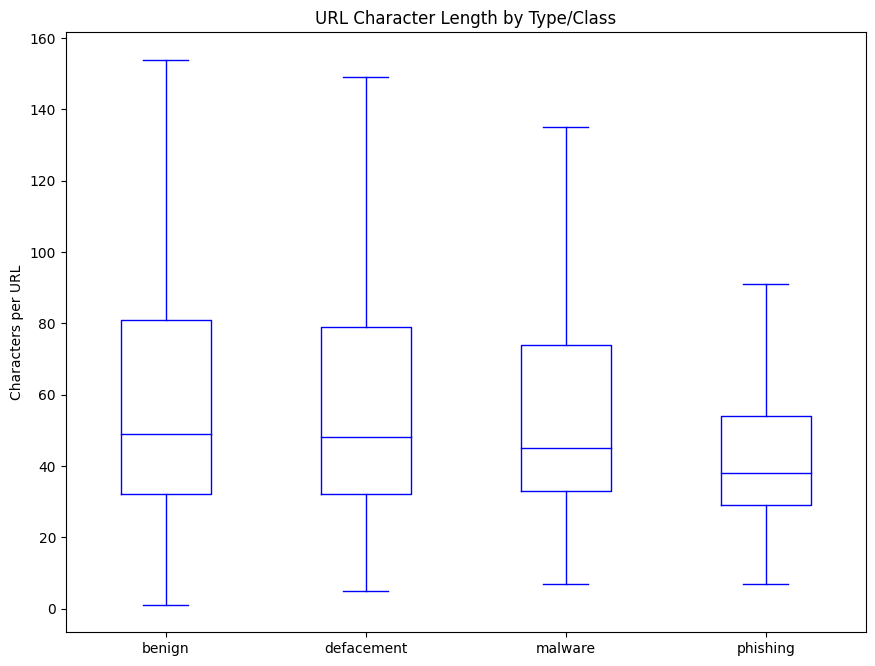

In [7]:
data.boxplot("text_length", by="label", grid=False, showfliers=False, color="Blue", figsize=(10,8))

plt.suptitle('')
plt.title('URL Character Length by Type/Class')
plt.xlabel('')
plt.ylabel('Characters per URL')
plt.show()

#### Final Data Preprocessing

In [8]:
data = data[data['text_length'] < 146]

data = data.drop(columns=["text_length"])

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 616088 entries, 0 to 641118
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    616088 non-null  object
 1   label   616088 non-null  object
dtypes: object(2)
memory usage: 14.1+ MB


#### Barplot Function

In [9]:
def barplot_visual(feature_to_visualize: pd.Series,
                   plot_title: str,
                   x_label: str,
                   y_label: str = "# of Samples",
                   show_class_amounts: bool = True
                   ):
    """
    This function returns a histogram for a feature.
    
    Inputs: 
    - feature_to_visualize: Feature to plot in the form 
    of pandas Series.
    - plot_title: The title of the plot/visual.
    - x_label: The string label value for the x label.
    - y_label: The string label value for the y label.
    
    Output:
    - A Bar Plot.
    """
    
    assert type(feature_to_visualize) == pd.Series, \
        "Make sure the dataset input type is a Pandas Series."
    assert type(plot_title) != 'str', \
        "The title value must be a string value."
    assert type(x_label) !=  'str', \
        "The x label value must be a string value."
    assert type(y_label) != 'str', \
        "The y label value must be a string value."
        
    ax = feature_to_visualize.value_counts().plot.bar( 
                                                      figsize=(8, 6),
                                                      rot=0, 
                                                      legend=False,
                                                      color=["lightgreen", 
                                                             "blue", 
                                                             "brown", 
                                                             "lightblue",
                                                             "tan", 
                                                             "yellow", 
                                                             "orange",
                                                             "green", 
                                                             "red"]
                                                      )
    
    if show_class_amounts:
        ax.bar_label(ax.containers[0])
    
    plt.suptitle('')
    plt.title(plot_title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    
    plt.show()

#### Number of Samples in Each Class

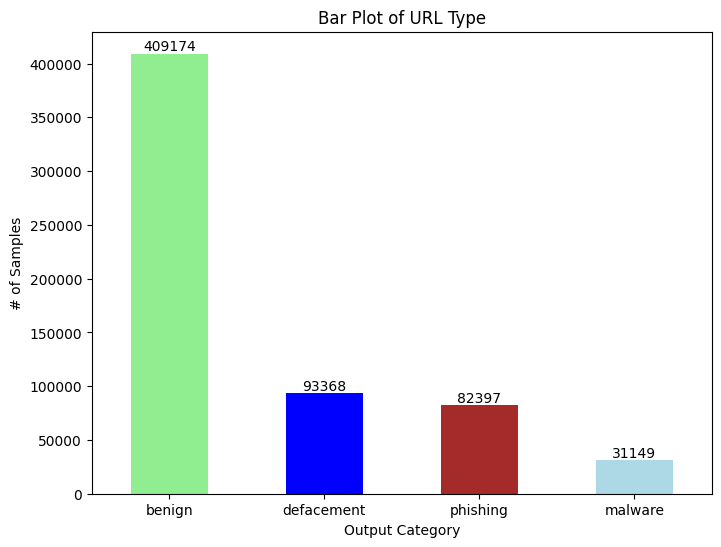

In [10]:
barplot_visual(data["label"],
               "Bar Plot of URL Type",
               "Output Category",
               "# of Samples",
               )

#### Convert Label Values From String to Integer

In [11]:
data['label'] = data['label'].replace(label2id).astype(np.int8)

#### Convert DataFrame to Dataset

In [12]:
dataset = Dataset.from_pandas(data)

#### Split Dataset into Training Evaluation Datasets

In [13]:
train_eval = dataset.train_test_split(train_size=0.67)

ds = DatasetDict({
    'train' : train_eval['train'],
    'eval' : train_eval['test'],
})

print("Training Dataset Shape:", ds['train'].shape)
print("Evaluation Dataset Shape:", ds['eval'].shape)

Training Dataset Shape: (412778, 3)
Evaluation Dataset Shape: (203310, 3)


#### Find Longest Tokenized Input Value

In [14]:
MODEL_CKPT = "microsoft/codebert-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT, 
                                             truncation=True, 
                                             padding=True,
                                             batched=True, 
                                             batch_size=None)

text_len = [len(tokenizer.encode(a)) for a in dataset["text"]]

print(f"The longest article length is {max(text_len)} tokens.")

The longest article length is 176 tokens.


#### Basic Values/Constants

In [15]:
set_seed = 42
NUM_OF_EPOCHS = 1

BATCH_SIZE = 64
LEARNING_RATE = 2e-5

MAX_LENGTH = max(text_len)
MODEL_CKPT = "microsoft/codebert-base"
MODEL_NAME = MODEL_CKPT.split("/")[-1] + "-Malicious_URLs"

METRIC_NAME = "f1"
DEVICE = torch.device("cpu")

print(f"This project will utilize the {str(DEVICE).upper()} to train and evaluate.")
print(f"This project will have a maximum length for the input text of {MAX_LENGTH} tokens.")
print(f"The model checkpoint used for this project is: {MODEL_CKPT}")

This project will utilize the CPU to train and evaluate.
This project will have a maximum length for the input text of 176 tokens.
The model checkpoint used for this project is: microsoft/codebert-base


#### Tokenize Entire Dataset

In [16]:
# Define Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

# Tokenize Method
def tokenize(batch):
    return tokenizer(batch['text'], 
                     padding=True, 
                     truncation=True, 
                     max_length=MAX_LENGTH, 
                     return_tensors="pt")

# Tokenize entire dataset
encoded_data = ds.map(tokenize, batched=True, batch_size=None)

print('Training data shape:', encoded_data['train'].shape)
print('Validation data shape:', encoded_data['eval'].shape)

print(encoded_data['train'].features)
print(encoded_data['train'])

Map:   0%|          | 0/412778 [00:00<?, ? examples/s]

Map:   0%|          | 0/203310 [00:00<?, ? examples/s]

Training data shape: (412778, 5)
Validation data shape: (203310, 5)
{'text': Value(dtype='string', id=None), 'label': Value(dtype='int8', id=None), '__index_level_0__': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}
Dataset({
    features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 412778
})


#### Instantiate Model

In [17]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_CKPT,
    num_labels=NUM_OF_LABELS,
    id2label=id2label,
    label2id=label2id
    ).to(DEVICE)

Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be 

#### Define Function to Compute Metrics

In [18]:
def compute_metrics(p):
    """
    This function takes the predictions output from 
    trainer.evaluate & returns metrics (accuracy, F1, 
    recall, & precision) for a multiclass 
    classification project.
    """
    accuracy_metric = evaluate.load("accuracy")
    accuracy = accuracy_metric.compute(predictions=np.argmax(p.predictions, 
                                                             axis=1), 
                                       references=p.label_ids)['accuracy']
    
    ### ------------------- F1 scores -------------------
    
    f1_score_metric = evaluate.load("f1")
    weighted_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, 
                                                                      axis=1), 
                                                references=p.label_ids, 
                                                average='weighted')["f1"]
    
    micro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, 
                                                                   axis=1), 
                                             references=p.label_ids, 
                                             average='micro')['f1']
    
    macro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, 
                                                                   axis=1), 
                                             references=p.label_ids, 
                                             average='macro')["f1"]
    
    ### ------------------- recall -------------------
    
    recall_metric = evaluate.load("recall")
    weighted_recall = recall_metric.compute(predictions=np.argmax(p.predictions, 
                                                                  axis=1), 
                                            references=p.label_ids, 
                                            average='weighted')["recall"]
    
    micro_recall = recall_metric.compute(predictions=np.argmax(p.predictions, 
                                                               axis=1), 
                                         references=p.label_ids, 
                                         average='micro')["recall"]
    
    macro_recall = recall_metric.compute(predictions=np.argmax(p.predictions, 
                                                               axis=1), 
                                         references=p.label_ids, 
                                         average='macro')["recall"]
    
    ### ------------------- precision -------------------
    
    precision_metric = evaluate.load("precision")
    weighted_precision = precision_metric.compute(predictions=np.argmax(p.predictions, 
                                                                        axis=1), 
                                                  references=p.label_ids, 
                                                  average='weighted')["precision"]
    
    micro_precision = precision_metric.compute(predictions=np.argmax(p.predictions, 
                                                                     axis=1), 
                                               references=p.label_ids, 
                                               average='micro')["precision"]
    
    macro_precision = precision_metric.compute(predictions=np.argmax(p.predictions, 
                                                                     axis=1), 
                                               references=p.label_ids, 
                                               average='macro')["precision"]
    
    return {"accuracy" : accuracy, 
            "Weighted F1" : weighted_f1_score,
            "Micro F1" : micro_f1_score,
            "Macro F1" : macro_f1_score,
            "Weighted Recall" : weighted_recall,
            "Micro Recall" : micro_recall,
            "Macro Recall" : macro_recall,
            "Weighted Precision" : weighted_precision,
            "Micro Precision" : micro_precision,
            "Macro Precision" : macro_precision
            }

#### Define TrainingArguments

In [19]:
training_args = TrainingArguments(
    output_dir=MODEL_NAME,
    num_train_epochs=NUM_OF_EPOCHS,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE, 
    per_device_eval_batch_size=BATCH_SIZE, 
    weight_decay=0.01,
    log_level="error",
    logging_strategy='steps', 
    logging_steps=50,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_first_step=True,
    load_best_model_at_end=True,
    disable_tqdm=False,
    hub_private_repo=True,
    push_to_hub=True
)

#### Define Data Collator

In [20]:
data_collator = DataCollatorWithPadding(tokenizer, padding=True)

#### Subclass Trainer to Handle Class Imbalance

In [21]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0, 3.0, 4.0]))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

#### Instantiate Trainer

In [22]:
trainer = CustomTrainer(model=model, 
                  args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=encoded_data['train'], 
                  eval_dataset=encoded_data['eval'], 
                  data_collator=data_collator,
                  tokenizer=tokenizer)

Cloning https://huggingface.co/DunnBC22/codebert-base-Malicious_URLs into local empty directory.


#### Train Model

In [23]:
train_results = trainer.train()

/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/6450 [00:00<?, ?it/s]

{'loss': 1.2819, 'learning_rate': 1.9996899224806202e-05, 'epoch': 0.0}
{'loss': 1.0266, 'learning_rate': 1.9844961240310078e-05, 'epoch': 0.01}
{'loss': 0.9499, 'learning_rate': 1.9689922480620155e-05, 'epoch': 0.02}
{'loss': 0.9484, 'learning_rate': 1.9534883720930235e-05, 'epoch': 0.02}
{'loss': 0.9144, 'learning_rate': 1.937984496124031e-05, 'epoch': 0.03}
{'loss': 0.9173, 'learning_rate': 1.922480620155039e-05, 'epoch': 0.04}
{'loss': 0.9003, 'learning_rate': 1.9069767441860468e-05, 'epoch': 0.05}
{'loss': 0.8778, 'learning_rate': 1.8914728682170544e-05, 'epoch': 0.05}
{'loss': 0.9169, 'learning_rate': 1.875968992248062e-05, 'epoch': 0.06}
{'loss': 0.9032, 'learning_rate': 1.86046511627907e-05, 'epoch': 0.07}
{'loss': 0.8996, 'learning_rate': 1.8449612403100777e-05, 'epoch': 0.08}
{'loss': 0.8921, 'learning_rate': 1.8294573643410854e-05, 'epoch': 0.09}
{'loss': 0.8678, 'learning_rate': 1.813953488372093e-05, 'epoch': 0.09}
{'loss': 0.9001, 'learning_rate': 1.798449612403101e-05, '

  0%|          | 0/3177 [00:00<?, ?it/s]

/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.8224543333053589, 'eval_accuracy': 0.7279376321873002, 'eval_Weighted F1': 0.6507971557659186, 'eval_Micro F1': 0.7279376321873002, 'eval_Macro F1': 0.4611337331866032, 'eval_Weighted Recall': 0.7279376321873002, 'eval_Micro Recall': 0.7279376321873002, 'eval_Macro Recall': 0.4422328842084383, 'eval_Weighted Precision': 0.6256102704588931, 'eval_Micro Precision': 0.7279376321873002, 'eval_Macro Precision': 0.5436052184719382, 'eval_runtime': 32125.1383, 'eval_samples_per_second': 6.329, 'eval_steps_per_second': 0.099, 'epoch': 1.0}
{'train_runtime': 302460.8026, 'train_samples_per_second': 1.365, 'train_steps_per_second': 0.021, 'train_loss': 0.8433443996148516, 'epoch': 1.0}


#### Save Model & Metrics on Training Dataset

In [24]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/476M [00:00<?, ?B/s]

Upload file runs/May20_00-16-26_Brians-Mac-mini.local/events.out.tfevents.1684559792.Brians-Mac-mini.local.646…

To https://huggingface.co/DunnBC22/codebert-base-Malicious_URLs
   724b072..ae0691c  main -> main

To https://huggingface.co/DunnBC22/codebert-base-Malicious_URLs
   ae0691c..1801786  main -> main



***** train metrics *****
  epoch                    =                 1.0
  train_loss               =              0.8433
  train_runtime            = 3 days, 12:01:00.80
  train_samples_per_second =               1.365
  train_steps_per_second   =               0.021


#### Push Model to HuggingFace Hub

In [25]:
trainer.push_to_hub(commit_message="All Dunn!!!")

To https://huggingface.co/DunnBC22/codebert-base-Malicious_URLs
   1801786..0c21dc8  main -> main



'https://huggingface.co/DunnBC22/codebert-base-Malicious_URLs/commit/0c21dc8d6f70e3f517070d1dac62b4f0fb9c11b0'

### Notes & Other Takeaways From This Project
****
- These text inputs are slightly different than the inputs from other projects that I have trained. The inputs are not spam and the intent is not to measure sentiment, but rather this project seeks to find any reviews that need to be flagged, reviewed and potentially removed. 
- I am still trying to remember why I set this project up to log every 50 steps!
- The results are disappointing. When I have a chacne, I am going to train this project with the masked language model (mlm) version of CodeBERT.
****

### Citations
- Model Checkpoint
    > @misc{feng2020codebert, title={CodeBERT: A Pre-Trained Model for Programming and Natural Languages}, author={Zhangyin Feng and Daya Guo and Duyu Tang and Nan Duan and Xiaocheng Feng and Ming Gong and Linjun Shou and Bing Qin and Ting Liu and Daxin Jiang and Ming Zhou}, year={2020}, eprint={2002.08155}, archivePrefix={arXiv}, primaryClass={cs.CL}}